In [59]:
from fastai.data.transforms import RandomSplitter
from pathlib import Path
from torch import tensor
import zipfile, kaggle, torch
import numpy as np, pandas as pd
import sympy
import torch.nn.functional as F

In [4]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# Artigo 5 - Modelo linear e rede neural do zero

## 1. Introdução

Na aula 3 vimos como as redes neurais funcionam em seu nível mais baixo, e agora na aula 5 colocaremos o conhecimento em prática, criando uma rede neural do zero.

## 2. Objetivo

Criar uma rede neural do zero, utilizando as bibliotecas `Pytorch`, `numpy` e `pandas`.

## 3. Inspiração

Nesse artigo será usado o dataset da competição [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/overview), que propõe a criação de um modelo capaz de identificar se um passageiro da espaçonave Titanic foi transportado para outra dimensão por um acidente. 

<img src="assets/desc.png" alt="" width="600" /><br>

## 4. Execução
### 4.1 Limpando os dados

Primeiramente vamos baixar o dataset do Kaggle e extraí-lo:

In [5]:
path = Path('spaceship-titanic')
if not path.exists():
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

Podemos então criar e abrir o dataset de treino para visualizar as colunas e valores com que vamos trabalhar

In [6]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


Não podemos trabalhar com valores que não existem, então vamos checar se a tabela possui valores **NaN** (*not a number*):

In [7]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

O número na direita é a quantidade de valores **NaN** para cada coluna, para removê-los podemos tirar a moda entre os valores daquela coluna e usar o resultado para preencher o campo **NaN**.

In [8]:
modes = df.mode().iloc[0]
modes

PassengerId                0001_01
HomePlanet                   Earth
CryoSleep                    False
Cabin                      G/734/S
Destination            TRAPPIST-1e
Age                           24.0
VIP                          False
RoomService                    0.0
FoodCourt                      0.0
ShoppingMall                   0.0
Spa                            0.0
VRDeck                         0.0
Name            Alraium Disivering
Transported                   True
Name: 0, dtype: object

In [9]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

Vamos checar as colunas com valores numéricos:

In [10]:
df.describe(include=(np.number))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.728517,220.009318,448.434027,169.572300,304.588865,298.261820
std,14.355438,660.519050,1595.790627,598.007164,1125.562559,1134.126417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Temos algumas colunas que representam a quantidade de dinheiro gasta em diversos serviços da espaçonave, mas certos valores são extremamente maiores do que os outros, e como a coluna vai ser multiplicada por um coeficiente, as linhas com valores muito altos vão dominar o resultado. Veja no histograma a seguir: 

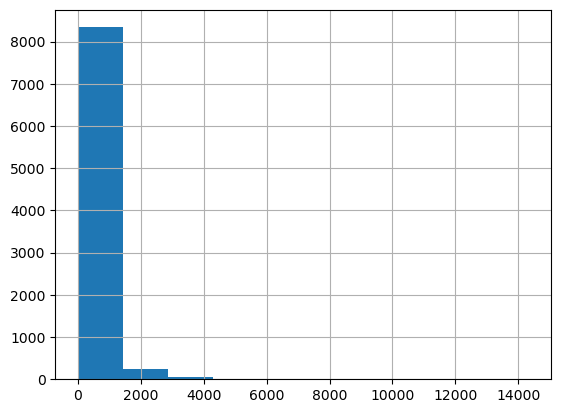

In [11]:
df['RoomService'].hist();

A grande maioria dos valores está entre 0 e 2000, mas existem valores que chegam a 14000. Para mitigar esse problema, podemos usar a função logaritmica para reduzir os números maiores:

In [12]:
df['LogRoomService'] = np.log(df['RoomService']+1)
df['LogFoodCourt'] = np.log(df['FoodCourt']+1)
df['LogShoppingMall'] = np.log(df['ShoppingMall']+1)
df['LogSpa'] = np.log(df['Spa']+1)
df['LogVRDeck'] = np.log(df['VRDeck']+1)

log_colums = ['LogRoomService', 'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck']

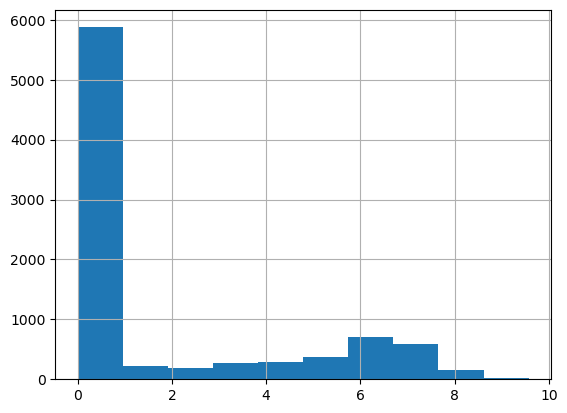

In [13]:
df['LogRoomService'].hist();

Nosso modelo precisa de números para multiplicar por coeficientes, então vamos transformar as colunas booleanas para int.

In [14]:
df['VIP'] = df['VIP'].astype(int)
df['Transported'] = df['Transported'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)

In [15]:
df[['VIP','Transported','CryoSleep']].head()

,VIP,Transported,CryoSleep
0,0,0,0
1,0,1,0
2,1,0,0
3,0,0,0
4,0,1,0


Agora vejamos as colunas não-numéricas:

In [16]:
df.describe(include=[object])

,PassengerId,HomePlanet,Cabin,Destination,Name
count,8693,8693,8693,8693,8693
unique,8693,3,6560,3,8473
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Alraium Disivering
freq,1,4803,207,6097,202


*HomePlanet* e *Destination* possuem apenas 3 valores possíveis, então podemos transformar cada um em sua própria coluna contendo 0 ou 1 para podermos utilizá-las.

In [17]:
df = pd.get_dummies(df, columns=['HomePlanet','Destination'])
df.columns

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'LogRoomService', 'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

Vamos visualizar os valores nessas colunas:

In [18]:
dummy_columns = ['HomePlanet_Earth', 'HomePlanet_Europa','HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']
df[dummy_columns].head()

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,1,0,0,0,1
1,1,0,0,0,0,1
2,0,1,0,0,0,1
3,0,1,0,0,0,1
4,1,0,0,0,0,1


Podemos criar nossas variáveis independentes (usadas na predição) e dependentes (que será inferido). Elas devem ser tensores do PyTorch.

In [19]:
t_dep = tensor(df.Transported)
indep_cols = ['Age','CryoSleep','VIP'] + log_colums + dummy_columns 

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep.shape

torch.Size([8693, 14])

### 4.2 Criando Modelo Linear

Com a matriz de variáveis independentes e o vetor de variável dependente podemos calcular as predições e a perda. Nessa seção vamos fazer manualmente um passo desse cálculo para cada linha.

O primeiro modelo será linear, e precisa de um coeficiente para cada coluna, então vamos pegar valores aleatórios entre `(-0.5, 0.5)`.

In [20]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5

In [21]:
t_indep*coeffs

tensor([[    17.7160,     -0.0000,     -0.0000,     -0.0000,      0.0000,     -0.0000,      0.0000,     -0.0000,      0.0000,      0.2863,
              0.0000,     -0.0000,     -0.0000,      0.4269],
        [    10.9021,     -0.0000,     -0.0000,     -0.9122,      0.0217,     -0.1827,      2.0796,     -0.9497,      0.3930,      0.0000,
              0.0000,     -0.0000,     -0.0000,      0.4269],
        [    26.3468,     -0.0000,     -0.2587,     -0.7343,      0.0772,     -0.0000,      2.9043,     -0.9760,      0.0000,      0.2863,
              0.0000,     -0.0000,     -0.0000,      0.4269],
        [    14.9904,     -0.0000,     -0.0000,     -0.0000,      0.0675,     -0.3319,      2.6731,     -1.3143,      0.0000,      0.2863,
              0.0000,     -0.0000,     -0.0000,      0.4269],
        [     7.2681,     -0.0000,     -0.0000,     -1.1094,      0.0402,     -0.2817,      2.0890,     -0.2741,      0.3930,      0.0000,
              0.0000,     -0.0000,     -0.0000,      0.42

Podemos ver que a coluna da Idade possui uma média muito maior do que as outras, o que pode afetar nosso modelo, então vamos restringir as colunas a valores de 0 a 1.

In [22]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals
t_indep*coeffs

tensor([[ 0.2243, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.2863,  0.0000, -0.0000, -0.0000,  0.4269],
        [ 0.1380, -0.0000, -0.0000, -0.0953,  0.0021, -0.0182,  0.2076, -0.0941,  0.3930,  0.0000,  0.0000, -0.0000, -0.0000,  0.4269],
        [ 0.3335, -0.0000, -0.2587, -0.0767,  0.0075, -0.0000,  0.2899, -0.0967,  0.0000,  0.2863,  0.0000, -0.0000, -0.0000,  0.4269],
        [ 0.1898, -0.0000, -0.0000, -0.0000,  0.0066, -0.0330,  0.2668, -0.1302,  0.0000,  0.2863,  0.0000, -0.0000, -0.0000,  0.4269],
        [ 0.0920, -0.0000, -0.0000, -0.1159,  0.0039, -0.0280,  0.2085, -0.0272,  0.3930,  0.0000,  0.0000, -0.0000, -0.0000,  0.4269],
        [ 0.2530, -0.0000, -0.0000, -0.0000,  0.0057, -0.0000,  0.1868, -0.0000,  0.3930,  0.0000,  0.0000, -0.0000, -0.3688,  0.0000],
        [ 0.1495, -0.0000, -0.0000, -0.0763,  0.0067, -0.0077,  0.0000, -0.0000,  0.3930,  0.0000,  0.0000, -0.0000, -0.0000,  0.4269],
        ...,
        [ 0.1840, -0.0000, -0.0000,

Podemos então somar as linhas do produto para criar inferências:

In [23]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([0.9375, 0.9600, 0.9120, 1.0132, 0.9533, 0.4696, 0.8921, 0.6600, 1.1882, 0.0168])

Para utilizar o método do gradiente devemos ter uma função de perda, então vamos criar uma que representa o erro médio das linhas:

In [24]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.6029)

Podemos então colocar esses cálculos dentro de funções para usar mais adiante.

In [25]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

### 4.3 Método do gradiente

Vamos fazer uma única época do método do gradiente. Para calcular os gradientes, devemos usar `requires_grad_()` nos coeficientes.

In [26]:
coeffs.requires_grad_()
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6029, grad_fn=<MeanBackward0>)

Para calcular os gradientes, usamos a função `backward()`:

In [27]:
loss.backward()
coeffs.grad

tensor([ 0.0310, -0.2479,  0.0022,  0.1009,  0.0628,  0.0568,  0.1237,  0.0907,  0.0926, -0.0632, -0.0121, -0.0465, -0.0423,  0.1062])

A cada chamada do `backward()` os gradientes são somados ao que estiver no atributo `grad`:

In [28]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 0.0620, -0.4958,  0.0044,  0.2018,  0.1257,  0.1136,  0.2474,  0.1814,  0.1852, -0.1263, -0.0242, -0.0929, -0.0847,  0.2124])

Por isso devemos tornar os gradientes em 0 depois de cada passo.  
Vamos realizar um passo e checar se a perda diminui:

In [29]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5656)


Obs: No PyTorch, métodos terminados em `_` realizam a operação *in-place*.

## 4.4 Treinando o modelo

Primeiro vamos separar um conjunto de dados para treino e outro para validação:

In [30]:
trn_split, val_split = RandomSplitter(seed=42)(df)

A função `RandomSplitter` vai retornar índices para separação dos dados. Esses índices podem então ser aplicados nos nossos valores dependentes e independentes.

In [31]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(6955, 1738)

Vamos criar funções para realizar os passos acima:

In [32]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

E usá-las para treinar o modelo.

In [33]:
coeffs = train_model(18, lr=0.2)

0.579; 0.555; 0.534; 0.514; 0.495; 0.476; 0.459; 0.443; 0.429; 0.417; 0.407; 0.398; 0.390; 0.383; 0.377; 0.370; 0.365; 0.360; 

Podemos ver nosso erro diminuindo a cada época. A seguir vamos printar os coeficientes para cada coluna:

In [34]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.3305),
 'CryoSleep': tensor(0.6607),
 'VIP': tensor(0.2288),
 'LogRoomService': tensor(-0.3421),
 'LogFoodCourt': tensor(-0.2167),
 'LogShoppingMall': tensor(-0.2984),
 'LogSpa': tensor(0.2199),
 'LogVRDeck': tensor(0.1036),
 'HomePlanet_Earth': tensor(0.0711),
 'HomePlanet_Europa': tensor(0.0077),
 'HomePlanet_Mars': tensor(0.1897),
 'Destination_55 Cancri e': tensor(0.4476),
 'Destination_PSO J318.5-22': tensor(0.2308),
 'Destination_TRAPPIST-1e': tensor(0.3062)}

#### Medindo acurácia

Como a métrica pedida na competição é a acurácia (proporção de inferências corretas), vamos ver quão bem nosso modelo se sai. Primeiramente devemos calcular as inferências:

In [35]:
preds = calc_preds(coeffs, val_indep)
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True, False,  True, False,  True, False, False,  True,  True,  True,  True,  True, False,  True,  True])

Acima, consideramos os casos em que a inferência é maior que 0.5 como positiva, ou seja, o passageiro foi transportado.

Vamos fazer uma função que calcula as inferências e retorna a acurácia:

In [40]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7658)

### 4.5 Função sigmoide

Um problema presente nas nossas predições é que existem valores menores que 0 e maiores que 1.

In [37]:
preds[:28]

tensor([ 0.2735,  0.9766,  0.2935,  0.8775, -0.0858,  0.3801,  0.1967,  0.2658,  0.1055,  0.1826, -0.0451,  1.0449,  0.0369,  0.9375,
         0.3003,  0.5145,  0.3104,  0.6256,  0.2463,  0.1494,  0.0617,  0.1662,  0.2300,  0.0520,  0.1825,  0.3023, -0.0547,  0.4959])

Isso pode ser resolvido passando os valores por uma função sigmoide, que varia entre 0 e 1 de acordo com a entrada:

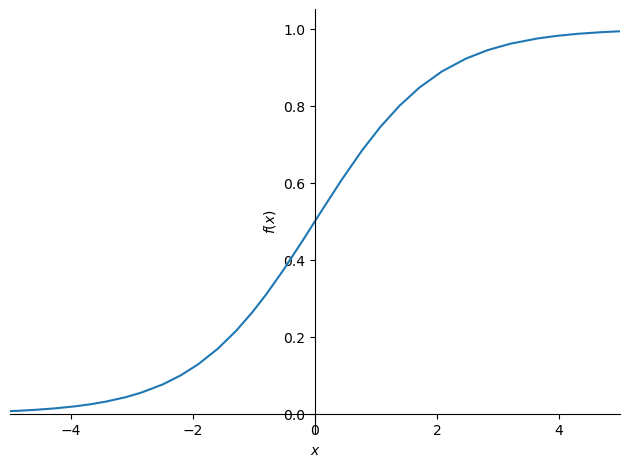

In [38]:
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

o `PyTorch` já possui essa função, então podemos modificar a `calc_preds` para incluí-la:

In [55]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

coeffs = train_model(lr=100)

0.511; 0.276; 0.273; 0.271; 0.269; 0.268; 0.267; 0.266; 0.265; 0.264; 0.262; 0.261; 0.260; 0.259; 0.257; 0.256; 0.254; 0.253; 0.251; 0.250; 0.249; 0.248; 0.247; 0.246; 0.245; 0.244; 0.243; 0.243; 0.242; 0.241; 

A perda diminuiu consideravelmente, agora vejamos a acurácia:

In [41]:
acc(coeffs)

tensor(0.7658)

O uso da função sigmoide acarretou em uma melhora de `0.74` para `0.76`.  
A seguir os coeficientes do nosso modelo:

In [42]:
show_coeffs()

{'Age': tensor(-1.7402),
 'CryoSleep': tensor(6.5644),
 'VIP': tensor(0.1634),
 'LogRoomService': tensor(-6.3714),
 'LogFoodCourt': tensor(2.8554),
 'LogShoppingMall': tensor(0.9213),
 'LogSpa': tensor(-6.5285),
 'LogVRDeck': tensor(-6.3461),
 'HomePlanet_Earth': tensor(-0.0955),
 'HomePlanet_Europa': tensor(2.9568),
 'HomePlanet_Mars': tensor(0.6349),
 'Destination_55 Cancri e': tensor(1.9058),
 'Destination_PSO J318.5-22': tensor(1.0360),
 'Destination_TRAPPIST-1e': tensor(1.2704)}

### 4.6 Conjunto de teste e submissão

Para gerar o arquivo de inferências e submeter ao kaggle, precisamos ver como o modelo se sai no conjunto de teste:

In [50]:
tst_df = pd.read_csv(path/'test.csv')

A seguir fazemos as mesmas adaptações da seção de limpeza dos dados:

In [51]:
tst_df.fillna(modes, inplace=True)
tst_df['LogRoomService'] = np.log(tst_df['RoomService']+1)
tst_df['LogFoodCourt'] = np.log(tst_df['FoodCourt']+1)
tst_df['LogShoppingMall'] = np.log(tst_df['ShoppingMall']+1)
tst_df['LogSpa'] = np.log(tst_df['Spa']+1)
tst_df['LogVRDeck'] = np.log(tst_df['VRDeck']+1)
tst_df['VIP'] = tst_df['VIP'].astype(int)
tst_df['CryoSleep'] = tst_df['CryoSleep'].astype(int)
tst_df = pd.get_dummies(tst_df, columns=['HomePlanet','Destination'])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

E geramos a coluna *Transported*, que é o nosso alvo, para guardar as inferências.

In [52]:
tst_df['Transported'] = (calc_preds(tst_indep, coeffs)>0.5)

Guardamos as colunas relevantes em outro dataframe, e exportamos ele para um arquivo `.csv`:

In [53]:
sub_df = tst_df[['PassengerId','Transported']]
sub_df.to_csv('sub.csv', index=False)

Aqui estão as primeiras linhas do arquivo:

In [54]:
!head sub.csv

PassengerId,Transported
0013_01,True
0018_01,False
0019_01,True
0021_01,False
0023_01,False
0027_01,False
0029_01,True
0032_01,True
0032_02,True


Agora é só enviar para o Kaggle.

#### Otimizações

Antes de prosseguir para a próxima parte, podemos fazer algumas otimizações.

O código `(indeps*coeffs).sum(axis=1)` nada mais é do que uma multiplicação de matrizes, e essa operação é suportada pelos tensores do PyTorch e representada pelo python através do operador `@`. A sua execução acaba sendo mais eficiente dessa forma, pois produto de matrizes é uma operação bem otimizada no PyTorch.

In [56]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

Acima atualizamos o `calc_preds` para utilizar a multiplicação de matrizes, e o `init_coeffs` para gerar nossos coeficientes em forma de um vetor coluna, ou seja, uma matriz com uma única coluna, para podermos realizar produtos entre matrizes na próxima seção.

Precisamos também transformar as variáveis dependentes em um vetor coluna. Isso pode ser feito indexando a coluna com o valor `None`, que diz ao PyTorch para adicionar uma dimensão nessa posição: 

In [57]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

### 4.6 Rede neural

Podemos enfim implementar uma rede neural.

Primeiramente devem ser criados coeficientes para cada camada. Os primeiros coeficientes vão tomar nossa entrada `n_coeff`, e criar um número de entradas `n_hidden`. Esse número pode ser o que o usuário quiser, sendo que um número maior oferece mais flexibilidade, mas torna a rede mais lenta e difícil de treinar.

Então teremos uma matriz de dimensão `n_coeff` por `n_hidden`. Esses coeficientes serão então divididos por `n_hidden` para termos números com a magnitude similar aos nossos iniciais após realizarmos a soma na próxima camada.

A segunda camada pegará as entradas `n_hidden` e retornará uma única saída, então precisamos de uma matriz de dimensão `n_hidden` por 1. A segunda camada também precisa de um termo constante adicionado.

In [58]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Podemos agora criar a rede neural.

Os passos essenciais são os dois produtos de matrizes:
1. `indeps@l1`: variáveis independentes * camada 1
2. `res@l2`: resultado da operação acima * camada 2

A saída da primeira camada é passada por uma função retificada linear, e a da segunda é passada por uma sigmoide.

Por fim, criamos um loop para atualizar cada conjunto de coeficientes:

In [60]:
def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Podemos agora treinar o modelo.

In [68]:
coeffs = train_model(lr=20)

0.497; 0.427; 0.328; 0.285; 0.273; 0.267; 0.263; 0.259; 0.255; 0.250; 0.247; 0.251; 0.255; 0.278; 0.267; 0.255; 0.238; 0.238; 0.247; 0.234; 0.236; 0.236; 0.243; 0.232; 0.233; 0.232; 0.234; 0.231; 0.232; 0.230; 

Nota-se uma melhora na perda. Vejamos a acurácia:

In [69]:
acc(coeffs)

tensor(0.7647)

Em termos de acurácia a performance da rede neural em contraste com o modelo linear não melhorou. Isso é de se esperar, visto que nosso dataset é simples e nosso conjunto de validação é pequeno.

### 5. Conclusão

Não é um procedimento muito prático, mas é muito gratificante construir uma rede neural do nada, especialmente após ter feito algumas com a ajuda de uma biblioteca como o fastai.

O que mais me chamou atenção nessa aula foi a parte de limpeza dos dados, principalmente as maneiras criativas de se tornar valores inutilizáveis em algo que nosso modelo possa processar.